## Prepaparacion de los Dataset para las funciones de los endpoints

In [78]:
# Se cargan las librerias necesarias
import pandas as pd
import numpy as np 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rolando\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Carga de todos los datasets

In [79]:
# Se cargan los datos
reviews = pd.read_csv('review_clean.csv', encoding='utf-8')
#items = pd.read_csv('item_clean.csv', encoding='utf-8')
items = pd.read_parquet('item_clean.parquet', engine='auto')
games = pd.read_csv('games_clean.csv', encoding='utf-8')

### Análisis de sentimientos
Se crea una nueva columna llamada 'sentiment_analysis' que reemplace a 'reviews_review' donde se realice un análisis de sentimiento.
La clasificacion sera:

* 0 si es malo,
* 1 si es neutral o esta sin review
* 2 si es positivo.

Se usa el SentimentIntensityAnalyzer  para realizar el analisis NLP.
Se usaron los umbrales -0.05 y 0.05 para realizar la clasificacion. Mayor a 0.05 es positivo, menor a -0.05 negativo y entre -0.05 - 0.05 como neutral


In [80]:
# Instanciar el analizador de sentimientos VADER
sia = SentimentIntensityAnalyzer()

sentiment_scores = []
for opinion in reviews['rev_review']:
    # Obtener el puntaje de sentimiento para cada opinión
    sentiment = sia.polarity_scores(opinion)
    
    # Clasificar la opinión según el puntaje obtenido
    if sentiment['compound'] >= 0.05:
        sentiment_scores.append(2)  # Positivo
    elif sentiment['compound'] <= -0.05:
        sentiment_scores.append(0)  # Negativo
    else:
        sentiment_scores.append(1)  # Neutral

# Añadir los resultados al DataFrame como una nueva columna
reviews['sentiment_analysis'] = sentiment_scores
reviews.drop('rev_review', inplace=True, axis=1)
reviews.to_csv('reviews_sa.csv', index=False)

In [81]:
reviews.head()

,user_id,user_url,variable,rev_item_id,rev_helpful,rev_recommend,año,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,0,1250,No ratings yet,True,2011,2
1,js41637,http://steamcommunity.com/id/js41637,0,251610,15 of 20 people (75%) found this review helpful,True,2014,2
2,evcentric,http://steamcommunity.com/id/evcentric,0,248820,No ratings yet,True,invalido,2
3,doctr,http://steamcommunity.com/id/doctr,0,250320,2 of 2 people (100%) found this review helpful,True,2013,2
4,maplemage,http://steamcommunity.com/id/maplemage,0,211420,35 of 43 people (81%) found this review helpful,True,2014,1


In [82]:
items['item_id'] = items['item_id'].astype(int)
items.head()

,item_id,item_name,playtime_forever,playtime_2weeks,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...


In [83]:
games['id'] = games['id'].astype(int)
games.head()

,publisher,genres,app_name,title,price,early_access,id,developer,rel_year
0,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,4.99,0.0,761140,Kotoshiro,2018
1,Kotoshiro,Casual,Lost Summoner Kitty,Lost Summoner Kitty,4.99,0.0,761140,Kotoshiro,2018
2,Kotoshiro,Indie,Lost Summoner Kitty,Lost Summoner Kitty,4.99,0.0,761140,Kotoshiro,2018
3,Kotoshiro,Simulation,Lost Summoner Kitty,Lost Summoner Kitty,4.99,0.0,761140,Kotoshiro,2018
4,Kotoshiro,Strategy,Lost Summoner Kitty,Lost Summoner Kitty,4.99,0.0,761140,Kotoshiro,2018


### Analisis Dataframe items

In [84]:
# Se toman las columnas necesarias para el analisis
items_analisis = items[['item_id',  'playtime_forever', 'user_id']]
items_analisis = items_analisis.drop_duplicates()
items_analisis

,item_id,playtime_forever,user_id
0,10,6,76561197970982479
1,20,0,76561197970982479
2,30,7,76561197970982479
3,40,0,76561197970982479
4,50,0,76561197970982479
...,...,...,...
5153204,346330,0,76561198329548331
5153205,373330,0,76561198329548331
5153206,388490,3,76561198329548331
5153207,521570,4,76561198329548331


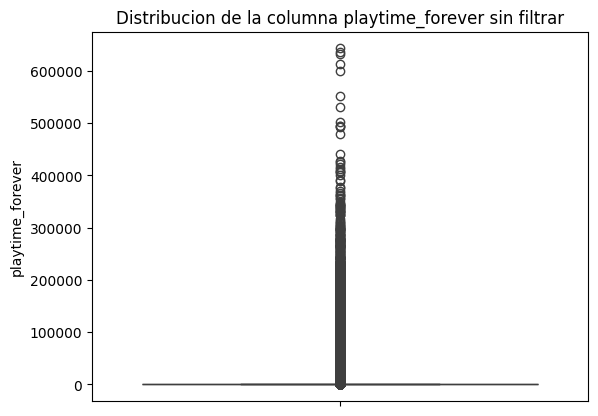

In [85]:
# Se grafica la distribucion de horas acumuladas jugadas por un usuario
sns.boxplot(y=items_analisis['playtime_forever'])

# Mostrar el gráfico
plt.title('Distribucion de la columna playtime_forever sin filtrar')
plt.show()

Como se puede ver hay muchos outliers, muy grandes  que no permiten apreciar los detalles del grafico, tambien se puede ver muchos valores 0. <br>
Se procede a filtrar el dataframe tomando valores teniendo un criterio que se explicara mas adelante



In [86]:
filtro = (items_analisis['playtime_forever'] > 0) & (items_analisis['playtime_forever'] <= 10000)
items_analisis_filtrado = items_analisis[filtro]
items_analisis_filtrado

,item_id,playtime_forever,user_id
0,10,6,76561197970982479
2,30,7,76561197970982479
8,300,4733,76561197970982479
9,240,1853,76561197970982479
10,3830,333,76561197970982479
...,...,...,...
5153202,304930,677,76561198329548331
5153203,227940,43,76561198329548331
5153206,388490,3,76561198329548331
5153207,521570,4,76561198329548331


In [87]:
# Se hace un segundo filtro para ver la cantidad de filas que quedaron pore fuera del filtro anterior
filtro2 = (items_analisis['playtime_forever'] > 10000) & (items_analisis['playtime_forever'].max())
analisis_mayor = items_analisis[filtro2]
analisis_mayor

,item_id,playtime_forever,user_id
46,1250,10006,76561197970982479
104,8930,10345,76561197970982479
155,35450,14194,76561197970982479
178,730,23532,76561197970982479
465,72850,13831,js41637
...,...,...,...
5150894,304930,13572,76561198288092724
5150968,730,29789,sexyawp
5151088,730,16635,tarik22
5152561,304930,20201,76561198304604920


Se grafica ahora el dataframe filtrado

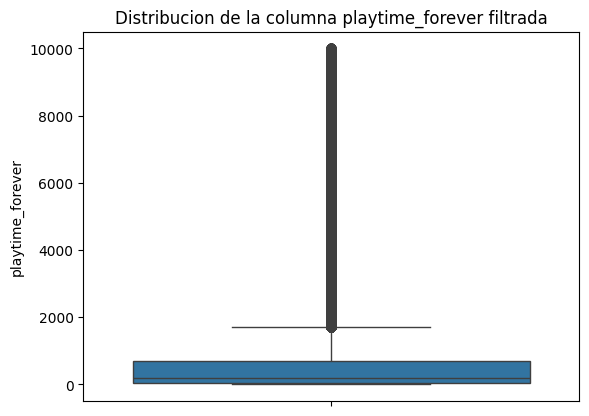

In [88]:
sns.boxplot(y=items_analisis_filtrado['playtime_forever'])

# Mostrar el gráfico
plt.title('Distribucion de la columna playtime_forever filtrada')
plt.show()

Se grafica el dataframe con los valores que estan por fuera del filtro aplicado

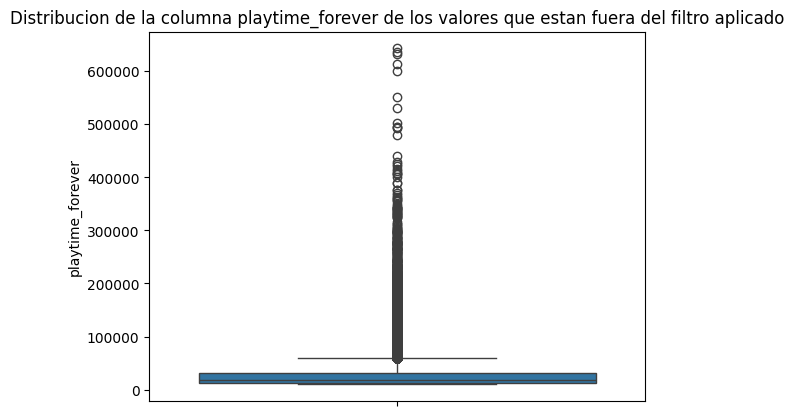

In [89]:
sns.boxplot(y=analisis_mayor['playtime_forever'])
# Mostrar el gráfico
plt.title('Distribucion de la columna playtime_forever de los valores que estan fuera del filtro aplicado')
plt.show()

Se muestran la lista de los años en que se hicieron los lanzamientos al mercado de los juegos

In [90]:
games.rel_year.unique()

array(['2018', '2017', 'No_disponible', '1997', '1998', '2016', '2006',
       '2005', '2003', '2007', '2002', '2000', '1995', '1996', '1994',
       '2001', '1993', '2004', '1999', '2008', '2009', '1992', '1989',
       '2010', '2011', '2013', '2012', '2014', '1983', '1984', '2015',
       '1990', '1988', '1991', '1987', '1986', '2021', '5275', '2019',
       '1985'], dtype=object)

Teniendo en cuenta todo lo mostrado en las grafica y en la informacion anterior, puede llegar a tener sentido que un juego lanzado en los 80's o 90' pueda tener <br>
un acumulado de horas jugadas mayor a 6000. Pero esto no se puede estimar con los datos que se tienen, se deberia tener un promedio de horas de juego de los usuarios, <br>
la moda o la media, para estimar de una manera mas exacta que valores tendrian mas sentido, porque definitivamente valores mayores a 100.00 estan fuera de toda logica. <br>

Para el presente trabajo se tomo la decision simplemente de trabajar con el rango donde se encuentre la MAYORIA de datos, aunque se puede perder informacion importante <br> 
se cree que es la mejor decision que se puede tomar con la actual informacion. <br>

Se va a trabajar con el 96.89% de los datos relevantes como se muestra a continuacion, teniendo en cuenta que se descarto  playtime_forever = 0 para estos calculos.

In [91]:
porcentaje =  (1 - len(analisis_mayor) / len(items_analisis_filtrado)) * 100
print(f"Se va atrabajar con un: {porcentaje:.2f}% de la cantidad de datos iniciales relevantes")                                                                                     


Se va atrabajar con un: 96.89% de la cantidad de datos iniciales relevantes


Se filtra el dataframe inicial items teniendo en cuenta lo anterior.

In [92]:
filtro_def = (items['playtime_forever'] > 0) & (items['playtime_forever'] <= 10000)
items = items[filtro_def]
items

,item_id,item_name,playtime_forever,playtime_2weeks,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
8,300,Day of Defeat: Source,4733,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
9,240,Counter-Strike: Source,1853,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
10,3830,Psychonauts,333,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
...,...,...,...,...,...,...,...,...
5153202,304930,Unturned,677,677,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153203,227940,Heroes & Generals,43,43,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153206,388490,One Way To Die: Steam Edition,3,3,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153207,521570,You Have 10 Seconds 2,4,4,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...


### Dataset para la Funcion PlayTimeGenre

Para devolver el año con mas horas jugadas en un determinado genero, se necesita los datos de games e items.<br>
Se toman las columnas necesarias para lograr el objetivo


In [93]:
games_play = games[['id', 'genres', 'rel_year']] 
items_play = items[['item_id', 'item_name', 'playtime_forever', 'user_id']]

# Se cambia el nombre de la fila id por item_id para realizar la union de una forma mas clara
games_play = games_play.rename(columns={'id':'item_id'})


Se hace la union entre items_mod y  games_mod

In [94]:
playtime = items_play.merge(games_play, on='item_id')
playtime =  playtime.drop_duplicates()

Al hacer el Deploy en render se presento un inconveniente por falta de memoria, entonces se determino simplificar aun mas los datasets <br>
para que corrieran en esta plataforma

In [95]:
playtime = playtime.groupby(['genres', 'rel_year'])['playtime_forever'].sum().reset_index()
playtime.shape

(351, 3)

In [96]:
playtime.to_csv('playtime.csv', index=False)
print(f'Se guardó el archivo')

Se guardó el archivo


### Dataset para la Funcion UserForGenre

Para devolver el usuario que acumula mas horas jugadas para un determinado genero y una lista de la acumulacion de horas jugadas por año,<br>
se necesita los datos de games e items<br>
Se toman las columnas necesarias para lograr este objetivo

In [97]:
games_user = games[['id', 'genres', 'rel_year']] 
items_user = items[['item_id', 'playtime_forever', 'user_id']]

# Se cambia el nombre de la fila id por item_id para realizar la union de una forma mas clara
games_user = games_user.rename(columns={'id':'item_id'})


Se hace la union de items_user y games_user

In [98]:
userfor = games_user.merge(items_user, on='item_id')
userfor.drop_duplicates(inplace=True)
userfor = userfor[userfor['playtime_forever'] != 0]

Se simplifica mas el dataset para que la funcion pueda correr en el deploy de render. <br>
Se agrupa con el fin de obtener los usuarios que mas horas han jugado en determinado genero

In [99]:
# Se agrupa y se  suman las horas jugadas por usuario, género y año
userfor_group = userfor.groupby(['user_id', 'genres', 'rel_year'])['playtime_forever'].sum().reset_index()

# Se buscan los índices de las filas con el máximo 'playtime_forever' por género
idx = userfor_group.groupby('genres')['playtime_forever'].idxmax()

# Obtener los 'user_id' correspondientes a esos índices
user_filtro = userfor_group.loc[idx].groupby('genres')['user_id'].apply(list)

Con la lista de usuarios que mas juegan un genero, se filtra el dataset para no solo tener el dato, sino para poder mostrar cuantas <br>
horas ha jugado cada año en ese genero.

In [100]:
userfor = userfor_group[userfor_group['user_id'].isin(user_filtro.explode())]

In [101]:
userfor.to_csv('userfor.csv', index=False)
print(f'Se guardó el archivo')

Se guardó el archivo


### Dataset para la Funcion UsersRecommend 

Para devolver el top 3 de juegos mas recomendados por usuarios para el año dado <br>
Se usa el dataset reviews y games. Se dejan solo las columnas necesarias

In [102]:
reviews_user_recom = reviews[['rev_item_id', 'user_id',  'rev_recommend', 'año', 'sentiment_analysis']]
games_user_recom =  games[['id', 'app_name']]

# Se cambia el nombre de la fila id por rev_item_id para realizar la union de una forma mas clara
games_user_recom = games_user_recom.rename(columns={'id':'rev_item_id'})

Se hace la union entre reviews_user_recom y games_user_recom

In [103]:
user_recom = reviews_user_recom.merge(games_user_recom, on='rev_item_id')
user_recom = user_recom.drop_duplicates()
# Se elimina el valor invalido en la columna año
user_recom['año'] = user_recom['año'].replace('invalido', pd.NA)
user_recom = user_recom.dropna(subset=['año'])

# Se vuelve una columna integer ya que estaba object
user_recom['año'] = user_recom['año'].astype('Int64')

Se filtran y ase agrupan los datos para obtener un dataset mas sencillo y se pueda usar en render

In [104]:
# Se crea una copia y se filtran los datos para que solo queden los juegos recomendados y con un sentiment_analysis de 2
filtro = user_recom[(user_recom['rev_recommend'] == True) & (user_recom['sentiment_analysis'] == 2)].copy()

# Se crea una columna de votos para poder encontrar los mas recomendados
filtro['total_votes'] = filtro['rev_recommend'].astype(int) + filtro['sentiment_analysis']

# Se agrupan por año y juego, se todos los votos por juego y año
filtro_group = filtro.groupby(['año', 'rev_item_id', 'app_name'])['total_votes'].sum().reset_index()

# Se encuentran los tres juegos con más votos para cada año
top_3_year = filtro_group.groupby('año', as_index=False).apply(lambda x: x.nlargest(3, 'total_votes'))

# Seleccionamos las columnas utiles para la funcion de la api
result = top_3_year[['año', 'app_name']]

# Se convierte en un  DataFrame final
result = pd.concat([group.reset_index(drop=True) for _, group in result.groupby('año')])

In [105]:
result.to_csv('user_recom.csv', index=False)
print(f'Se guardó el archivo')

Se guardó el archivo


### Dataset para la Funcion UsersWorstDeveloper 

Para devolver el top 3 de las desarrolladoras con juegos menos recomendados por usuarios para el año dado <br>
Se usa el dataset reviews y games. Se dejan solo las columnas necesarias

In [106]:
reviews_worst = reviews[['rev_item_id', 'user_id',  'rev_recommend', 'año', 'sentiment_analysis']]
games_worst =  games[['id', 'developer']]

# Se cambia el nombre de la fila id por rev_item_id para realizar la union de una forma mas clara
games_worst = games_worst.rename(columns={'id':'rev_item_id'})

Se hace la union entre reviews_worst y games_worst

In [107]:
user_worst = reviews_worst.merge(games_worst, on='rev_item_id')
user_worst = user_worst.drop_duplicates()
# Se elimina el valor invalido en la columna año
user_worst['año'] = user_worst['año'].replace('invalido', pd.NA)
user_worst = user_worst.dropna(subset=['año'])

# Se vuelve una columna integer ya que estaba object
user_worst['año'] = user_worst['año'].astype('Int64')

Se ajusta el dataset para que su tamaño sea el ideal para trabajar en render

In [108]:
# Se crea una copia y se filtran los datos para que solo queden los juegos NO recomendados y con un sentiment_analysis de 0
filtro_no_recomendados = user_worst[(user_worst['rev_recommend'] == False) & (user_worst['sentiment_analysis'] == 0)].copy()

# Se agrupan por año y desarrollador, y se cuentan los juegos no recomendados 
develop_no_recomendados = filtro_no_recomendados.groupby(['año', 'developer'])['rev_item_id'].count().reset_index()

# Se cambia el nombre de la columna para hacerlo mas claro
develop_no_recomendados.rename(columns={'rev_item_id': 'cantidad_no_recomend'}, inplace=True)

# Se encuentran los tres desarrolladores con más juegos no recomendados para cada año
top_3_peores_developers = develop_no_recomendados.groupby('año', as_index=False).apply(lambda x: x.nlargest(3, 'cantidad_no_recomend'))

# Seleccionamos las columnas relevantes
peores_developers = top_3_peores_developers[['año', 'developer']]
# Convertimos en un DataFrame final
user_worst = pd.concat([group.reset_index(drop=True) for _, group in peores_developers.groupby('año')])

In [109]:
user_worst.to_csv('user_worst.csv', index=False)
print(f'Se guardó el archivo')

Se guardó el archivo


### Dataset para la Funcion sentiment_analysis

Segun la empresa desarrolladora se devuelve un diccionario donde la clave es la desarrolladora y una lista con la cantidad total de registros<br>
positivos, negativos y neutrales. <br>
Se usa el dataset reviews y games. Se dejan solo las columnas necesarias

In [110]:
reviews_sa = reviews[['rev_item_id', 'user_id',  'sentiment_analysis']]
games_sa =  games[['id', 'developer']]

# Se cambia el nombre de la fila id por rev_item_id para realizar la union de una forma mas clara
games_sa = games_sa.rename(columns={'id':'rev_item_id'})

In [111]:
sa = reviews_sa.merge(games_sa, on='rev_item_id')
sa = sa.drop_duplicates()

Se ajusta el dataset para que su tamaño sea el ideal para trabajar en render

In [112]:
# Agrupar por 'developer' y 'sentiment_analysis', contar los valores
agrupar = sa.groupby(['developer', 'sentiment_analysis']).size().reset_index(name='count')

# Crear una tabla pivote con 'developer' como índice, 'sentiment_analysis' como columnas y 'count' como valores
pivot_table = agrupar.pivot_table(index='developer', columns='sentiment_analysis', values='count', fill_value=0)

Se ajusta el dataset para que su tamaño sea el ideal para trabajar en render

In [113]:
# Agrupar por 'developer' y 'sentiment_analysis', contar los valores
grouped = sa.groupby(['developer', 'sentiment_analysis']).size().reset_index(name='count')

# Crear una tabla pivote con 'developer' como índice, 'sentiment_analysis' como columnas y 'count' como valores
pivot_table = grouped.pivot_table(index='developer', columns='sentiment_analysis', values='count', fill_value=0).rename_axis(None, axis=1)

# Se le cambia el tipo a las columnas 0 1 2
columnas_para_cambiar = [0, 1, 2]
pivot_table[columnas_para_cambiar] = pivot_table[columnas_para_cambiar].astype(int)

# Se renombran las columnas del DataFrame pivot_table
pivot_table.rename(columns={0: 'Negative', 1: 'Neutral', 2: 'Positive'}, inplace=True)

In [114]:
pivot_table.to_csv('sa.csv', index=True)
print(f'Se guardó el archivo')

Se guardó el archivo
